In [2]:
# This notebook compares the dopamine signal aligned to movement during the CoT task to the
# dopamine signal evoked by white noise sounds played while the mouse is freely moving right after its CoT session.

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%cd APE_paper/docs/figures_notebooks
!git checkout YvonneJohansson

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import urllib.request
from os.path import exists
import matplotlib.pylab as plt
import numpy as np
import pickle
from scipy.signal import decimate

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))))
from scripts import YJ_analysis_utils as yj_utils
from scripts import yj_plotting as yj_plot

In [6]:
# Extended Data 5X & 5Y:

# Get dataset information:
dataset_name = 'DataOverview_ED5XY.csv'
zenodo = "https://zenodo.org/records/10852859/files/"
url = zenodo + dataset_name
dataset_path = '../../data/' + dataset_name

if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

In [7]:
info

,Unnamed: 0,AnimalID,Date,fiber_side,protocol1,protocol2
0,1,TS32,20231128,right,LRO,RWN
1,2,TS33,20231128,right,LRO,RWN
2,3,TS34,20231128,right,LRO,RWN


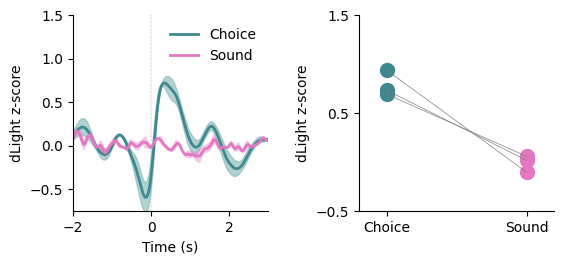

In [8]:
# load mouse data from zenodo and run basic analysis of the CoT session

x_range = [-2, 3]
y_range = [-0.75, 1.5]
nr_mice = len(info['AnimalID'].unique())
for m, mouse in enumerate(info['AnimalID']):
    date = str(info[info['AnimalID']==mouse]['Date'].values[0])
    fiber_side = info[info['AnimalID']==mouse]['fiber_side'].values[0]
    protocol = info[info['AnimalID']==mouse]['protocol1'].values[0]
    dataset_names = []
    # CoT session
    CoT_trial_data = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_data = mouse + '_' + date + '_smoothed_signal.npy' 
    # RTC session 
    RWN_trial_data = mouse + '_' + date + '_RWN_restructured_data.pkl'
    RWN_photo_data = mouse + '_' + date + '_RWN_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_data,CoT_trial_data, RWN_photo_data, RWN_trial_data])


    for i, dataset_name in enumerate(dataset_names):
        url = zenodo + dataset_name
        dataset_path = '../../data/' + dataset_name
        
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')

        
        
        if i == 0:
            photometry_data = np.load(dataset_path)  
            
        if i == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)
            file_name = mouse + '_' + date + '_aligned_traces.p'
            dataset_path = '../../data/' + file_name           
            pickle.dump(session_traces, open(dataset_path, "wb"))
        if i == 2: 
            RWN_photometry_data = np.load(dataset_path)    
            
        if i == 3:
            RWN_trial_data = pd.read_pickle(dataset_path)
            RWN_data = yj_utils.ZScoredTraces_RTC(RWN_trial_data, RWN_photometry_data, x_range)

            APE_aligned_data = decimate(session_traces.choice.contra_data.mean_trace, 10)
            APE_time = decimate(session_traces.choice.contra_data.time_points,10)
            APE_sem_traces = decimate(session_traces.choice.contra_data.sorted_traces,10)
            RWN_aligned_data = decimate(RWN_data.mean_trace, 10)
            RWN_time = decimate(RWN_data.time_points, 10)

            if m == 0:
                APE_traces = np.zeros((nr_mice, len(APE_aligned_data)))
                RWN_traces = np.zeros((nr_mice, len(RWN_aligned_data)))
                APE_sem_traces_upper = np.zeros((nr_mice, len(APE_aligned_data)))
                APE_sem_traces_lower = np.zeros((nr_mice, len(APE_aligned_data)))
                RWN_sem_traces_upper = np.zeros((nr_mice, len(RWN_aligned_data)))
                RWN_sem_traces_lower = np.zeros((nr_mice, len(RWN_aligned_data)))
                APE_peak_values = []
                RWN_peak_values = []

            APE_traces[m,:] = APE_aligned_data
    
            RWN_traces[m,:] = RWN_aligned_data

            # get the peak values:   # APE_time: 16000 datapoints, half: 8000 datapoints = time 0, only consider time after 0
            start_inx = 8000
            APE_range = APE_aligned_data[start_inx:start_inx+8000]
            APE_time_range = APE_time[start_inx:start_inx+8000]
            RWN_range = RWN_aligned_data[start_inx:start_inx+8000]

            APE_peak_index = np.argmax(APE_range) # from time 0 to 8s
            APE_peak_time = APE_time_range[APE_peak_index]
            APE_peak_value = APE_range[APE_peak_index]
            RWN_peak_value = RWN_range[APE_peak_index]
            APE_peak_values.append(APE_peak_value)
            RWN_peak_values.append(RWN_peak_value)

# calculate mean and sem across mice:
APE_mean_trace = np.mean(APE_traces, axis=0)
RWN_mean_trace = np.mean(RWN_traces, axis=0)
APE_sem_trace = np.std(APE_traces, axis=0)/np.sqrt(nr_mice)
RWN_sem_trace = np.std(RWN_traces, axis=0)/np.sqrt(nr_mice)

figure = yj_plot.plot_ED5VW(APE_mean_trace, RWN_mean_trace, APE_sem_trace, RWN_sem_trace, APE_peak_values, RWN_peak_values, APE_time, RWN_time)

# uncomment here to save the plot
#dataset_path = '../../data/'
#plt.savefig(dataset_path + 'ED5XY.png',
#            transparent=True, bbox_inches='tight')